In [2]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import os
import math

#from mpltools import special ##leon

class RawData(object):
    def __init__(self,timestamp,keytime,ttime,keypress,targetid,target_lon,target_lat,target_x,target_y,target_z,hmd_rx,hmd_ry,hmd_rz):
        self.timestamp=timestamp
        self.keytime=keytime
        self.ttime=ttime
        self.keypress=keypress
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.target_x=target_x
        self.target_y=target_y
        self.target_z=target_z
        self.hmd_rx=hmd_rx
        self.hmd_ry=hmd_ry
        self.hmd_rz=hmd_rz

def read_data(file,rawdata):
    print("Reading %s"%file)
    seperator="\t"
    with open(file,"r") as fp:
        for line in fp:
            if line.startswith("Time"):
                continue
            l=line[:-1]
            f=l.split(seperator) 
            if(int(f[3])==1):
                rawdata.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),float(f[5]),float(f[6]),float(f[7]),float(f[8]),float(f[9]),float(f[10]),float(f[11]),float(f[12])))
            else: 
                rawdata.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),0,0,0,0,0,0,float(f[10]),float(f[11]),float(f[12])))
                
            
    return rawdata

#def read_data(file,rawdata):
#    print("Reading %s"%file)
#    seperator="\t"
#    with open(file,"r") as fp:
#        for line in fp:
#            if line.startswith("Time"):
#                continue
#            l=line[:-1]
#            f=l.split(seperator) 
#            if(int(f[3])==1):
#                rawdata.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),float(f[5]),float(f[6]),float(f[7]),float(f[8]),float(f[9]),float(f[10]),float(f[11]),float(f[12])))
#            else: 
#                rawdata.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),0,0,0,0,0,0,float(f[10]),float(f[11]),float(f[12])))
#    return rawdata

class TimeData(object):
    def __init__(self,targetid,target_lon,target_lat,deltatime):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.deltatime=deltatime

def process_time(raw_data):
    timeData={}
    filteredData=[a for a in raw_data if a.keypress==1]
    for i in range(len(filteredData)-1):
        if(filteredData[i+1].targetid!=filteredData[i].targetid):
            continue
        if((i <= len(filteredData)-3) and (filteredData[i-1].targetid==filteredData[i+2].targetid)):
            continue #when two same targets appear one after one
        deltaTime=filteredData[i+1].ttime-filteredData[i].ttime
        #print(deltaTime, filteredData[i].targetid)

        key1=str(int(filteredData[i].target_lat))
        key2=str(int(filteredData[i].target_lon))
        if(key1 in timeData)==False:
            timeData[key1]={}
        if(key2 in timeData[key1])==False:
            timeData[key1][key2]=[]
        
        timeData[key1][key2].append(TimeData(filteredData[i].targetid,filteredData[i].target_lon,filteredData[i].target_lat,deltaTime))
#    timeData['0']['0'].append((21,0,0,0))
#    print(timeData['0'][str(180)])
        #print(key1, key2)
    return timeData

def plotTrial(raw_data,fig,raw,col,idx):
    #fig = plt.figure()
    ax = fig.add_subplot(raw,col,idx)
    for i in range(13):
        tx=[a.tx for a in raw_data if a.keypress==1]
        ty=[a.ty for a in raw_data if a.fittstrial==trial and a.tid==i]
        x=[a.x for a in raw_data if a.fittstrial==trial and a.tid==i]
        y=[a.y for a in raw_data if a.fittstrial==trial and a.tid==i]
        z=[a.z for a in raw_data if a.fittstrial==trial and a.tid==i]


        mpl.rcParams['legend.fontsize'] = 7

        ax.scatter(tx,ty)
        ax.plot(x, y, label='tid:'+str(i))
    #ax.legend()


def read_plot(path,raw,fig):
    raw_data=[]
    raw_data=read_data(path,raw_data)
    timeData=process_time(raw_data)
    key1=['-30','0','30']
    key2=[0,30,60,90,120,150,180]
    #return timeData


    means=[]
    stddev=[]
    for k1 in range(len(key1)):
        m1=[]
        s1=[]
        for k2 in range(len(key2)):
            if(k1==1 and k2==0):
                m1.append(0)
                s1.append(0)
                continue
            data=[a.deltatime for a in timeData[key1[k1]][str(key2[k2])]]
            mean=np.mean(data)
            std=np.std(data)
            
            m1.append(mean)
            s1.append(std)
        means.append(m1)
        stddev.append(s1)        
    return means


def make_ratio(mean_before, mean_after):
    
    ratio=[]
    
    for i in range(len(mean_before)):
        r=[]
        for j in range(len(mean_before[i])):
            if(mean_after[i][j]==0):
                r.append(1) #ratio
                #r.append(0) #log
                continue
            r.append(mean_before[i][j]/mean_after[i][j]) #ratio
            #r.append(math.log2(mean_before[i][j]/mean_after[i][j])) #log
            #print(i,j,mean_after[i][j],mean_before[i][j])
        ratio.append(r)
        
    return ratio
    

def plotratio(r,s=None):
    plt.figure(1, figsize = (8,8))
    key1=['-30','0','30']
    key2=[0,30,60,90,120,150,180]
    
    #print(r[0])    
    #print(r[2])
    
    if(s!=None):
        print(r[1],s[1],key2)
        #ar1 = np.array(r[1])
        #as1 = np.array(s[1])
        #print(ar1,as1)
        ymax=[[],[],[]]
        ymin=[[],[],[]]
        xmean=[[],[],[]]
        for j in range(3):
            #ymax[j] = []
            for i in range(7):
                ymax[j].append(r[j][i] + s[j][i])
                ymin[j].append(r[j][i] - s[j][i])
                xmean[j].append((r[0][i] + r[1][i] + r[2][i])/3)
            xmean[j][0] = (r[0][0] + r[2][0])/2                    
        #color='crimson', color="limegreen" color='C0'
        
###################### plot 3 latitude, with error/standard deviation  (old, bar)
        #plt.errorbar(key2, r[2], label="30", yerr=s[2], fmt='-x',color='crimson',markersize=10,elinewidth=0.5,capsize=10,capthick=0.5)
        #plt.errorbar(key2, r[1], label="0", yerr=s[1], linewidth=2, fmt = '-x',markersize=10, elinewidth=1,capsize=5,capthick=0.5)
        #plt.errorbar(key2, r[0], label="-30", yerr=s[0], fmt=':v',markersize=10,elinewidth=2,capsize=10,capthick=0.5)

        #ax.errorbar(key2, r[0], label="-30-2",yerr=s[0], linestyle='dotted')       
        #ax.fill_between(key2, np.array(r[1]-s[1]),np.array(r[1]+s[1]), facecolor='blue', alpha=0.5)
        #plt.fill_betweenx(key2,r[1]-s[1], r[1]+s[1])
        
###################### plot 3 latitude, with error/standard deviation (new, area/shade)   
        #plt.fill_between(np.array(key2), ymin[0], ymax[0],alpha=0.2, label="-30")
        #plt.fill_between(np.array(key2), ymin[1], ymax[1],alpha=0.2, label="0")
        #plt.fill_between(np.array(key2), ymin[2], ymax[2],alpha=0.2, label="30")
        #plt.plot(key2, r[0], ':v', label="-30")
        #plt.plot(key2, r[1], '-o', label="0")
        #plt.plot(key2, r[2], ':^', label="30")
        
###################### plot single latitude
        pltid = 0;
        ##plt.fill_between(np.array(key2), ymin[pltid], ymax[pltid],alpha=0.2, label=key1[pltid],color='C'+ str(pltid))
        ##plt.plot(key2, r[pltid], '-x', markersize=10, label=key1[pltid],color='C'+ str(pltid), linewidth =2)
        plt.plot(key2, xmean[1], '-x', markersize=10, label='all', color='black', linewidth =2) #combine all latitude
######################
    else:
        plt.plot(key2, r[0], ':v', label="-30") 
        plt.plot(key2, r[1], '-o', label="0")
        plt.plot(key2, r[2], ':^', label="30")
    
#    special.errorfill(key2, means1[0], y_err=stddev1[0], label='sin', label_fill='sin error')
#    special.errorfill(x, y_cos, y_err, label='cos', label_fill='cos error',alpha_fill=0.1)
#    plt.fill_between(key2, means1[2]-stddev1[2], means1[2]+stddev1[2])
###################### set figure scale
    #plt.axhline(y=0,linewidth=1, color='r') #log
    plt.axhline(y=1,linewidth=1, color='r') #ratio
    plt.xticks(key2)
    #plt.ylim(-1,1) #log
    plt.ylim(0.9,1.4) #ratio
######################    
    plt.xlim(-10)    
    #plt.rcParams["axes.grid.axis"] ="y"
    #plt.rcParams["axes.grid"] = True
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    plt.legend(title="latitude", loc = 4)
    plt.ylabel('ratio')
    #plt.ylabel('log')
    plt.xlabel('target longtitude')

    plt.savefig('user'+str(users[uid])+'.pdf')
    plt.show()
    


Reading ../Users/1/1.txt
Reading ../Users/1/2.txt


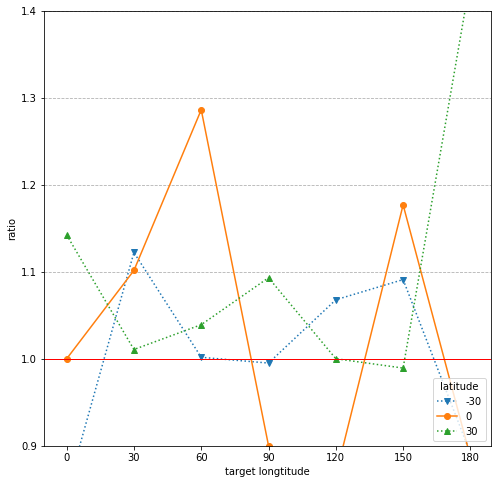

Reading ../Users/2/1.txt
Reading ../Users/2/2.txt


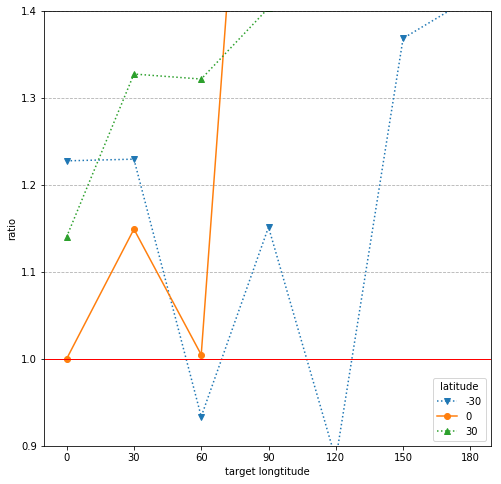

Reading ../Users/3/1.txt
Reading ../Users/3/2.txt


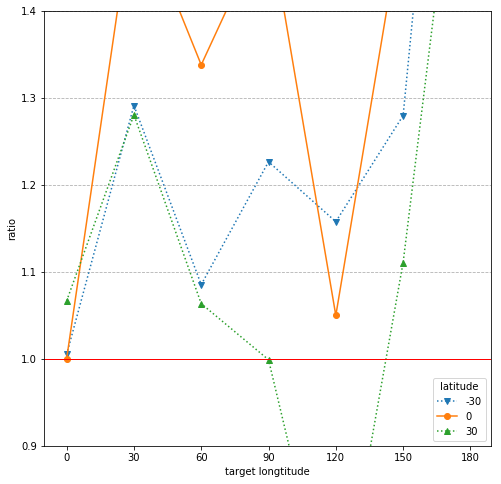

Reading ../Users/4/1.txt
Reading ../Users/4/2.txt


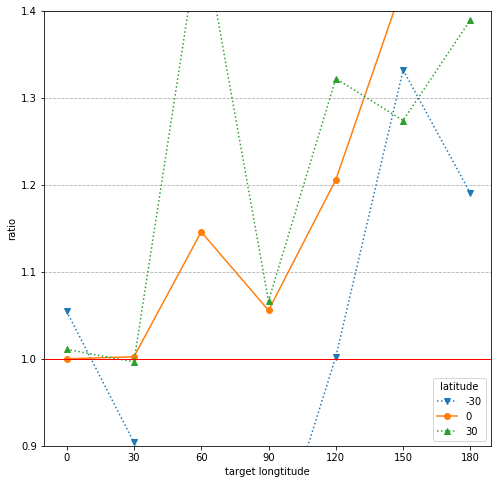

Reading ../Users/5/1.txt
Reading ../Users/5/2.txt


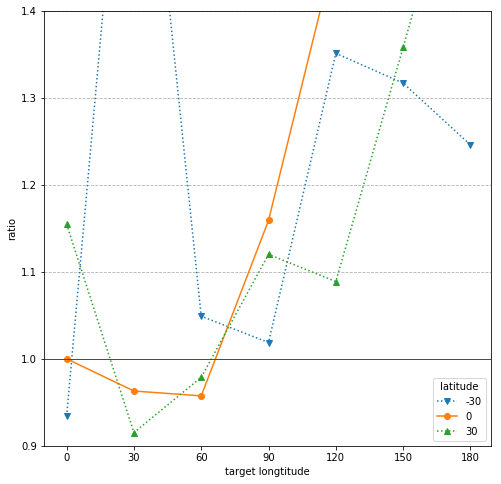

Reading ../Users/9/1.txt
Reading ../Users/9/2.txt


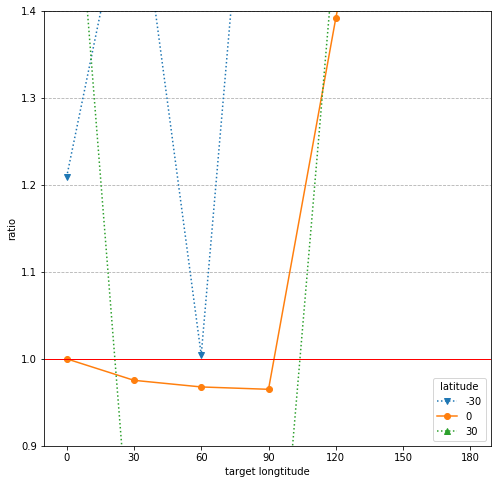

Reading ../Users/10/1.txt
Reading ../Users/10/2.txt


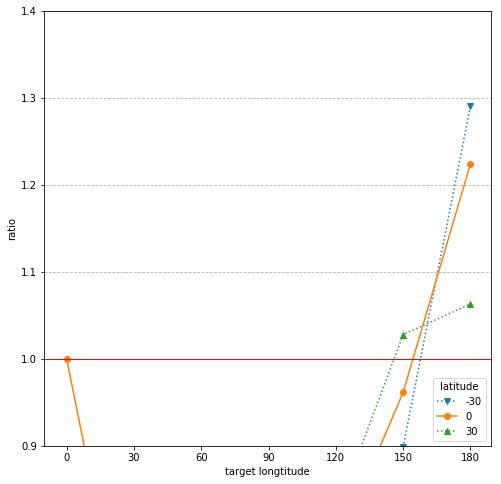

Reading ../Users/14/1.txt
Reading ../Users/14/2.txt


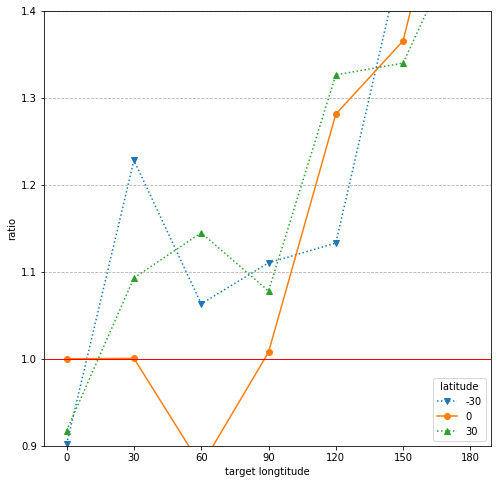

Reading ../Users/6/1.txt
Reading ../Users/6/2.txt


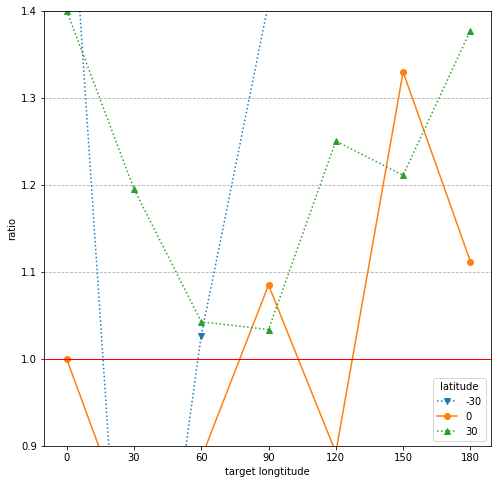

Reading ../Users/13/1.txt
Reading ../Users/13/2.txt


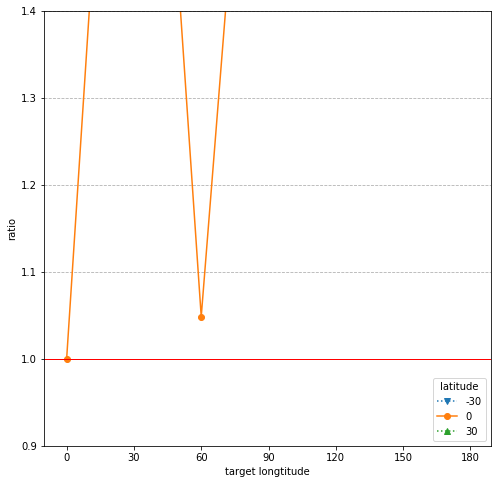

In [3]:
fig, ax = plt.subplots(figsize=(8,8))
ratio=[[],[],[]]
###################### choose user
users=[1,2,3,4,5,9,10,14,6,13]#,8,12,11]#,7]
######################
for uid in range(len(users)):
    baseFolder=str(users[uid])

    idx=[1,2]

   # for i in range(len(idx)):
    #print("Trial 1"+str(i))
    t1=read_plot("../Users/"+baseFolder+"/"+str(idx[0])+".txt",1,fig)
    #print("Trial 2"+str(i))
    t2=read_plot("../Users/"+baseFolder+"/"+str(idx[1])+".txt",1,fig)
    r=make_ratio(t1,t2)
    ratio[0].append(r[0])
    ratio[1].append(r[1])
    ratio[2].append(r[2])
    plotratio(r)
    
  

[1.0, 1.0658532236726497, 1.0544314761833113, 1.1033955062439784, 1.1381114931798364, 1.2085532750009422, 1.3012406621801926] [0.0, 0.30268467599772353, 0.2657926474583625, 0.32852148897227434, 0.35679930179366515, 0.42918180931745165, 0.5606619995540827] [0, 30, 60, 90, 120, 150, 180]


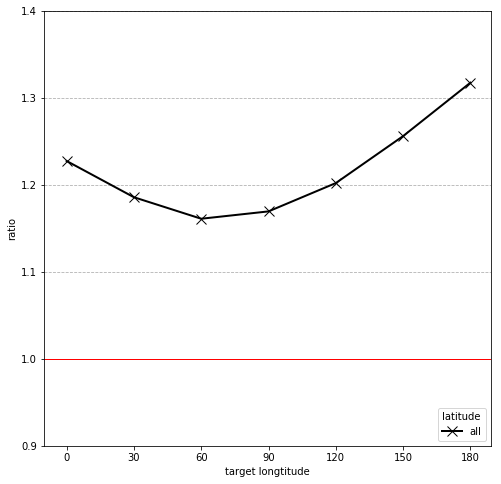

In [4]:
  
ratioDiv=[[],[],[]]
meanR=[[],[],[]]
StdR=[[],[],[]]
#print(np.array(ratio).shape)
for i in range(7):
    for j in range(3):
        r=[]
        for k in range(len(ratio[j])):
            ratioDiv[j].append(ratio[j][k][i])
        meanR[j].append(np.mean(ratioDiv[j]))
        StdR[j].append(np.std(ratioDiv[j]))
        #StdR[j].append(np.std(ratioDiv))
    
#print(np.array(meanR).shape)
#print(meanR,StdR)
plotratio(meanR,StdR)
